In [1]:
import numpy as np
from numpy import random
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
import kf_book.book_plots as bp

## Fixed-Interval Smoothing

There are many fixed-lag smoothers available in the literature. I have chosen to implement the smoother invented by Rauch, Tung, and Striebel because of its ease of implementation and efficiency of computation. It is also the smoother I have seen used most often in real applications. This smoother is commonly known as an **RTS smoother**.

The RTS smoother works by first running the Kalman filter in a batch mode, computing the filter output for each step. Given the filter output for each measurement along with the covariance matrix corresponding to each output the RTS runs over the data backwards, incorporating its knowledge of the future into the past measurements. When it reaches the first measurement it is done, and the filtered output incorporates all of the information in a maximally optimal form.

The equations for the RTS smoother are very straightforward and easy to implement. This derivation is for the linear Kalman filter. Similar derivations exist for the EKF and UKF. These steps are performed on the output of the batch processing, going backwards from the most recent in time back to the first estimate. Each iteration incorporates the knowledge of the future into the state estimate. Since the state estimate already incorporates all of the past measurements the result will be that each estimate will contain knowledge of all measurements in the past and future. Here is it very important to distinguish between past, present, and future so I have used subscripts to denote whether the data is from the future or not.

```
Predict Step
```

$$\begin{aligned}
\mathbf{P} &= \mathbf{FP}_k\mathbf{F}^\mathsf{T} + \mathbf{Q }
\end{aligned}$$

```
Update Step
```

$$\begin{aligned}
\mathbf{K}_k &= \mathbf{P}_k\mathbf{F}^\mathsf{T}\mathbf{P}^{-1} \\
\mathbf{x}_k &= \mathbf{x}_k + \mathbf{K}_k(\mathbf{x}_{k+1} - \mathbf{Fx}_k) \\
\mathbf{P}_k &= \mathbf{P}_k + \mathbf{K}_k(\mathbf{P}_{k+1} - \mathbf{P})\mathbf{K}_k^\mathsf{T}
\end{aligned}$$
As always, the hardest part of the implementation is correctly accounting for the subscripts. A basic implementation without comments or error checking would be:

```python
def rts_smoother(Xs, Ps, F, Q):
    n, dim_x, _ = Xs.shape

    # smoother gain
    K = zeros((n,dim_x, dim_x))
    x, P, Pp = Xs.copy(), Ps.copy(), Ps.copy

    for k in range(n-2,-1,-1):
        Pp[k] = dot(F, P[k]).dot(F.T) + Q # predicted covariance

        K[k]  = dot(P[k], F.T).dot(inv(Pp[k]))
        x[k] += dot(K[k], x[k+1] - dot(F, x[k]))
        P[k] += dot(K[k], P[k+1] - Pp[k]).dot(K[k].T)
    return (x, P, K, Pp)
```

This implementation mirrors the implementation provided in FilterPy. It assumes that the Kalman filter is being run externally in batch mode, and the results of the state and covariances are passed in via the ```Xs``` and ```Ps``` variable.

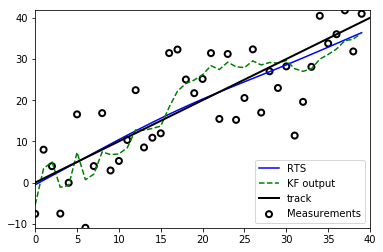

In [2]:
def plot_rts(noise, Q=0.001, show_velocity=False):
    random.seed(123)
    fk = KalmanFilter(dim_x=2, dim_z=1)

    fk.x = np.array([0., 1.])      # state (x and dx)

    fk.F = np.array([[1., 1.],
                     [0., 1.]])    # state transition matrix

    fk.H = np.array([[1., 0.]])    # Measurement function
    fk.P = 10.                     # covariance matrix
    fk.R = noise                   # state uncertainty
    fk.Q = Q                       # process uncertainty

    # create noisy data
    zs = np.asarray([t + randn()*noise for t in range (40)])

    # filter data with Kalman filter, than run smoother on it
    mu, cov, _, _ = fk.batch_filter(zs)
    M, P, C, _ = fk.rts_smoother(mu, cov)

    # plot data
    if show_velocity:
        index = 1
        print('gu')
    else:
        index = 0
    if not show_velocity:
        bp.plot_measurements(zs, lw=1)
    plt.plot(M[:, index], c='b', label='RTS')
    plt.plot(mu[:, index], c='g', ls='--', label='KF output')
    if not show_velocity:
        N = len(zs)
        plt.plot([0, N], [0, N], 'k', lw=2, label='track') 
    plt.legend(loc=4)
    plt.show()
    
plot_rts(7.)

I've injected a lot of noise into the signal to allow you to visually distinguish the RTS output from the ideal output. In the graph above we can see that the Kalman filter, drawn as the green dotted line, is reasonably smooth compared to the input, but it still wanders from from the ideal line when several measurements in a row are biased towards one side of the line. In contrast, the RTS output is both extremely smooth and very close to the ideal output.

With a perhaps more reasonable amount of noise we can see that the RTS output nearly lies on the ideal output. The Kalman filter output, while much better, still varies by a far greater amount.

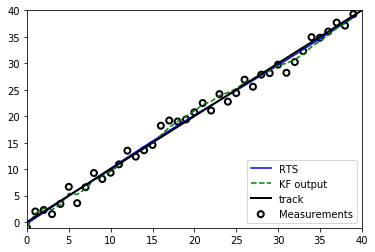

In [3]:
plot_rts(noise=1.)

However, we must understand that this smoothing is predicated on the system model. We have told the filter that what we are tracking follows a constant velocity model with very low process error. When the filter **looks ahead** it sees that the future behavior closely matches a constant velocity so it is able to reject most of the noise in the signal. Suppose instead our system has a lot of process noise. For example, if we are tracking a light aircraft in gusty winds its velocity will change often, and the filter will be less able to distinguish between noise and erratic movement due to the wind. We can see this in the next graph

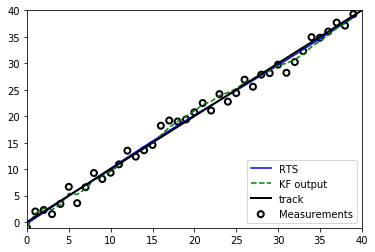

In [4]:
plot_rts(noise=1.)

This underscores the fact that these filters are not *smoothing* the data in colloquial sense of the term. The filter is making an optimal estimate based on previous measurements, future measurements, and what you tell it about the behavior of the system and the noise in the system and measurements.

Let's wrap this up by looking at the velocity estimates of Kalman filter vs the RTS smoother.

gu


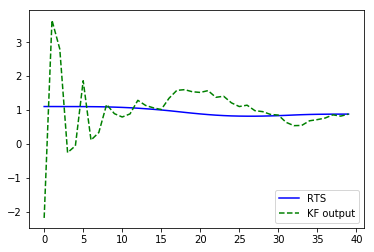

In [5]:
plot_rts(7.,show_velocity=True)